# ESGF Distributed array example

In [1]:
import cdms2
import numpy as np
import dask.array.ma as dma
import dask.array as da
import dask
from dask_kubernetes import KubeCluster
from dask.distributed import LocalCluster
from dask.distributed  import Client

## Create a Cluster
* 5 workers
* 2 threads

In [2]:
cluster=LocalCluster(n_workers=5,threads_per_worker=2)
display(cluster)
c=Client(cluster)
c

/Users/nadeau1/miniconda3/envs/binder/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:58629 Dashboard: http://127.0.0.1:58630/status,Cluster Workers: 5 Cores: 10 Memory: 28.63 GB


# Read CMIP6 data
* CNRM-CM6 piControl
* Atmospheric temperature (ta)
* aggregate 2 netcdf files using `cdscan`
* 36524 days --> 100 years
* 8 pressure levels (1000, 850, 700, 500, 250, 100, 50, 10hPa)
* grid of 1.4x1.4 degrees (128x256)

In [3]:
!wget http://cdat.llnl.gov/cdat/sample_data/so_Omon_ACCESS1-0_historical_r1i1p1_185001-185412_2timesteps.nc

URL transformed to HTTPS due to an HSTS policy
--2018-12-28 12:50:04--  https://cdat.llnl.gov/cdat/sample_data/so_Omon_ACCESS1-0_historical_r1i1p1_185001-185412_2timesteps.nc
Resolving cdat.llnl.gov... 198.128.245.146
Connecting to cdat.llnl.gov|198.128.245.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47528456 (45M) [application/x-netcdf]
Saving to: 'so_Omon_ACCESS1-0_historical_r1i1p1_185001-185412_2timesteps.nc'

so_Omon_ACCESS1-0_h 100%[===================>]  45.33M  72.3MB/s    in 0.6s    

2018-12-28 12:50:05 (72.3 MB/s) - 'so_Omon_ACCESS1-0_historical_r1i1p1_185001-185412_2timesteps.nc' saved [47528456/47528456]



In [4]:
#f=cdms2.open("ta_day_CNRM-CM6-1_piControl_r1i1p1f2_gr_18500101-18991231.nc")
# f=cdms2.open("ta_day_CNRM-CM6-1_piControl_r1i1p1f2_gr.xml")
f=cdms2.open("so_Omon_ACCESS1-0_historical_r1i1p1_185001-185412_2timesteps.nc")
dataDV=f['so']
print(dataDV.shape)
dataDV


(2, 50, 300, 360)


In [5]:
# dmaTV=dma.masked_array(dataTV)

daDV=da.from_array(dataDV,chunks=(1,1,300,360),asarray=False)
daDV

dask.array<array, shape=(2, 50, 300, 360), dtype=float32, chunksize=(1, 1, 300, 360)>

In [6]:
%time result = da.mean(daDV, axis=0).compute()
print(result.shape)
result



CPU times: user 759 ms, sys: 160 ms, total: 918 ms
Wall time: 2.23 s
(50, 300, 360)


masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        ...,

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --,

In [7]:
import vcs
axes=dataDV.getAxisList()
resultsCDMS=cdms2.createVariable(result[1,:],axes=axes[2:])
canvas=vcs.init()
cmap = vcs.createcolormap("my_colormap9", "rainbow")

box = vcs.createboxfill()
box.color_1 = 10
box.color_2 = 240
[resultsCDMS.setattribute(name, dataDV.getattribute(name)) for name in dataDV.listattributes()]
resultsCDMS.id='so'

In [8]:
box.level_1=30
box.level_2=40

In [9]:
resultsCDMS.getGrid()

/Users/nadeau1/miniconda3/envs/binder/lib/python3.6/site-packages/vcs-v8.0_53_gf83696d2-py3.7.egg/vcs/Canvas.py:3819: VCSDeprecationWarning: Deprecation Warning: Keyword 'long_name' will be removed in the next versionof UV-CDAT.
  "of UV-CDAT." % keyarg, vcs.VCSDeprecationWarning)


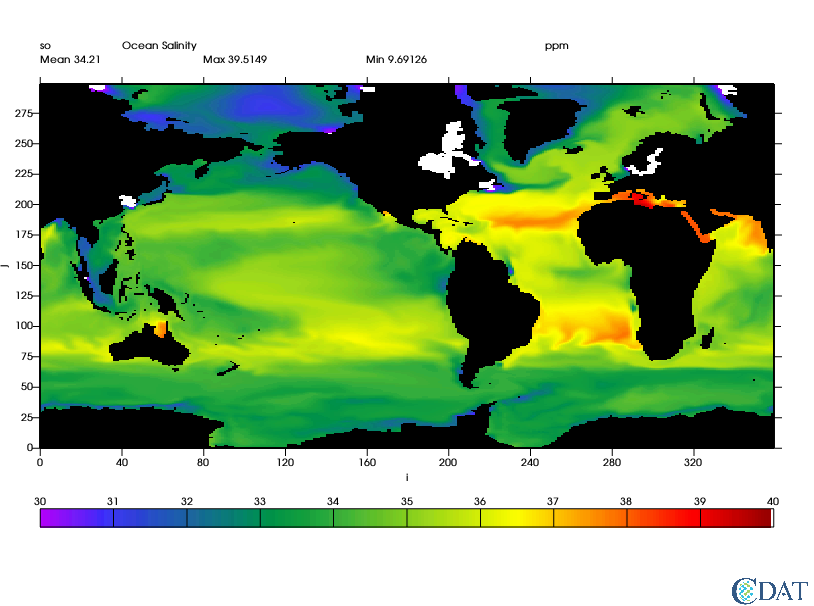

In [10]:
canvas.clear()
canvas.setcolormap(cmap)
canvas.plot(resultsCDMS,box, long_name="Ocean Salinity", units="ppm")

In [11]:
single_core_time = 5.75
dask_time=3.00
print("Serial: 5:44 minutes")
print("Parallel: with Demo and quicktime running 3 minutes")
print(((single_core_time - dask_time)/single_core_time)*100, "faster")
dask_time=2.00
print("Parallel: Without movie interference 2 minutes")
print(((single_core_time - dask_time)/single_core_time)*100, "faster")


Serial: 5:44 minutes
Parallel: with Demo and quicktime running 3 minutes
47.82608695652174 faster
Parallel: Without movie interference 2 minutes
65.21739130434783 faster


# ESGF Numba Example

## Serial 

In [12]:
import numpy as np
from numba import njit, prange
def two_d_array_reduction_prod_serial(n):
    shp = (13, 17)
    result1 = 2 * np.ones(shp, np.int_)
    tmp = 2 * np.ones_like(result1)
    for i in prange(n):
        result1 *= tmp
    return result1


## Parallel

In [13]:
@njit(parallel=True)
def two_d_array_reduction_prod_parallel(n):
    shp = (13, 17)
    result1 = 2 * np.ones(shp, np.int_)
    tmp = 2 * np.ones_like(result1)
    for i in prange(n):
        result1 *= tmp
    return result1


# Run reductions

## First Run Serial reduction

In [14]:
import time
stime = time.time()
%time two_d_array_reduction_prod_serial(5000000)
etime = time.time()
durationSerial = etime - stime
print("duration:",  durationSerial)

CPU times: user 5.99 s, sys: 90.7 ms, total: 6.08 s
Wall time: 6.04 s
duration: 6.037307977676392


## Second Run paralell reduction

In [16]:
import time
# compile first
two_d_array_reduction_prod_parallel(1)
stime = time.time()
%time two_d_array_reduction_prod_parallel(5000000)
etime = time.time()
durationPar = etime - stime
print("duration:", durationPar )
print(((durationSerial-durationPar)/durationSerial)*100,"% increase")

CPU times: user 1.91 s, sys: 7.15 ms, total: 1.92 s
Wall time: 181 ms
duration: 0.1812736988067627
96.99744158361571 % increase


In [17]:
import numpy.ma
import numpy
import dask
import dask.array.ma
from dask.distributed import Client
from distributed.deploy.local import LocalCluster

rand_data= numpy.random.random((20,18,365))
ma_rand_data= numpy.ma.MaskedArray(rand_data,chunks=(1,18,365))
da_rand_data = dask.array.ma.masked_array(ma_rand_data)
print(da_rand_data)
dask.array.average(da_rand_data).compute()

dask.array<masked_array, shape=(20, 18, 365), dtype=float64, chunksize=(20, 18, 365)>


0.49960100195044227